# Image classification with ConvMixer

**Author:** [Sayak Paul](https://twitter.com/RisingSayak)<br>
**Date created:** 2021/10/12<br>
**Last modified:** 2021/10/12<br>
**Description:** An all-convolutional network applied to patches of images.

## Introduction

Vision Transformers (ViT; [Dosovitskiy et al.](https://arxiv.org/abs/1612.00593)) extract
small patches from the input images, linearly project them, and then apply the
Transformer ([Vaswani et al.](https://arxiv.org/abs/1706.03762)) blocks. The application
of ViTs to image recognition tasks is quickly becoming a promising area of research,
because ViTs eliminate the need to have strong inductive biases (such as convolutions) for
modeling locality. This presents them as a general computation primititive capable of
learning just from the training data with as minimal inductive priors as possible. ViTs
yield great downstream performance when trained with proper regularization, data
augmentation, and relatively large datasets.

In the [Patches Are All You Need](https://openreview.net/pdf?id=TVHS5Y4dNvM) paper (note: at
the time of writing, it is a submission to the ICLR 2022 conference), the authors extend
the idea of using patches to train an all-convolutional network and demonstrate
competitive results. Their architecture namely **ConvMixer** uses recipes from the recent
isotrophic architectures like ViT, MLP-Mixer
([Tolstikhin et al.](https://arxiv.org/abs/2105.01601)), such as using the same
depth and resolution across different layers in the network, residual connections,
and so on.

In this example, we will implement the ConvMixer model and demonstrate its performance on
the CIFAR-10 dataset.

To use the AdamW optimizer, we need to install TensorFlow Addons:

```shell
pip install -U -q tensorflow-addons
```

## Imports

In [2]:
pip install -U -q tensorflow-addons

     |████████████████████████████████| 1.1 MB 4.9 MB/s 


In [3]:
from tensorflow.keras import layers
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf
import numpy as np

## Hyperparameters

To keep run time short, we will train the model for only 10 epochs. To focus on
the core ideas of ConvMixer, we will not use other training-specific elements like
RandAugment ([Cubuk et al.](https://arxiv.org/abs/1909.13719)). If you are interested in
learning more about those details, please refer to the
[original paper](https://openreview.net/pdf?id=TVHS5Y4dNvM).

In [4]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 10

## Load the CIFAR-10 dataset

In [12]:
!mkdir "dataset"
!unrar x "camel_Train.rar" "dataset"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from camel_Train.rar

Creating    dataset/camel_False                                       OK
Extracting  dataset/camel_False/01f4cxg6_2.png                             0%  OK 
Extracting  dataset/camel_False/01f4cxg6_4.png                             0%  OK 
Extracting  dataset/camel_False/01f4cxg6_5.png                             0%  OK 
Extracting  dataset/camel_False/01f4cxg6_6.png                             0%  OK 
Extracting  dataset/camel_False/01f4cxg6_7.png                             0%  OK 
Extracting  dataset/camel_False/02c4cqdb0.png                              0%  OK 
Extracting  dataset/camel_False/02c4cqdb1.png                              0%  OK 
Extracting  dataset/camel_False/02c4cqdb2.png                              0%  OK 
Extracting  dataset/camel_False/02c4cqdb4.png                              0%  O

In [6]:
import cv2
from sklearn.model_selection import train_test_split
import os

In [48]:
filenames = []
im_size = (50,50)
for _,_,filenames in os.walk("./dataset/camel_True/"):
  break
x_true = []
for name in filenames:
  im = cv2.imread("./dataset/camel_True/" +name)
  im = cv2.resize(im,im_size)
  x_true.append(im)
y_true = [1]*len(x_true)

In [49]:
filenames = []
for _,_,filenames in os.walk("./dataset/camel_False/"):
  break
x_false = []
for name in filenames:
  im = cv2.imread("./dataset/camel_False/" +name)
  im = cv2.resize(im,im_size)
  x_false.append(im)
y_false = [1]*len(x_false)

In [50]:
X = []
y = []
X.extend(x_true)
X.extend(x_false)
y.extend(y_true)
y.extend(y_false)
# X = np.array(X)
# y = np.array(y)

In [51]:
x_train, x_test, y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [52]:
import matplotlib.pyplot as plt


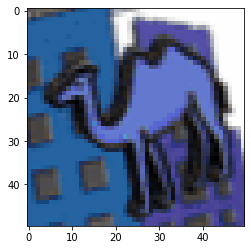

In [53]:
plt.imshow(x_train[0])

In [54]:
# (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
val_split = 0.1

val_indices = int(len(x_train) * val_split)
new_x_train, new_y_train = x_train[val_indices:], y_train[val_indices:]
x_val, y_val = x_train[:val_indices], y_train[:val_indices]

print(f"Training data samples: {len(new_x_train)}")
print(f"Validation data samples: {len(x_val)}")
print(f"Test data samples: {len(x_test)}")

Training data samples: 832
Validation data samples: 92
Test data samples: 232


## Prepare `tf.data.Dataset` objects

Our data augmentation pipeline is different from what the authors used for the CIFAR-10
dataset, which is fine for the purpose of the example.

In [43]:
new_x_train[0].shape

(47, 56, 3)

In [57]:
image_size = 50
auto = tf.data.AUTOTUNE

data_augmentation = keras.Sequential(
    [layers.RandomCrop(image_size, image_size), layers.RandomFlip("horizontal"),],
    name="data_augmentation",
)


def make_datasets(images, labels, is_train=False):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if is_train:
        dataset = dataset.shuffle(batch_size * 10)
    dataset = dataset.batch(batch_size)
    # if is_train:
    #     dataset = dataset.map(
    #         lambda x, y: (data_augmentation(x), y), num_parallel_calls=auto
    #     )
    return dataset.prefetch(auto)


train_dataset = make_datasets(new_x_train, new_y_train, is_train=True)
val_dataset = make_datasets(x_val, y_val)
test_dataset = make_datasets(x_test, y_test)

## ConvMixer utilities

The following figure (taken from the original paper) depicts the ConvMixer model:

![](https://i.imgur.com/yF8actg.png)

ConvMixer is very similar to the MLP-Mixer, model with the following key
differences:

* Instead of using fully-connected layers, it uses standard convolution layers.
* Instead of LayerNorm (which is typical for ViTs and MLP-Mixers), it uses BatchNorm.

Two types of convolution layers are used in ConvMixer. **(1)**: Depthwise convolutions,
for mixing spatial locations of the images, **(2)**: Pointwise convolutions (which follow
the depthwise convolutions), for mixing channel-wise information across the patches.
Another keypoint is the use of *larger kernel sizes* to allow a larger receptive field.

In [62]:

def activation_block(x):
    x = layers.Activation("gelu")(x)
    return layers.BatchNormalization()(x)


def conv_stem(x, filters: int, patch_size: int):
    x = layers.Conv2D(filters, kernel_size=patch_size, strides=patch_size)(x)
    return activation_block(x)


def conv_mixer_block(x, filters: int, kernel_size: int):
    # Depthwise convolution.
    x0 = x
    x = layers.DepthwiseConv2D(kernel_size=kernel_size, padding="same")(x)
    x = layers.Add()([activation_block(x), x0])  # Residual.

    # Pointwise convolution.
    x = layers.Conv2D(filters, kernel_size=1)(x)
    x = activation_block(x)

    return x


def get_conv_mixer_256_8(
    image_size=50, filters=256, depth=8, kernel_size=5, patch_size=2, num_classes=10
):
    """ConvMixer-256/8: https://openreview.net/pdf?id=TVHS5Y4dNvM.
    The hyperparameter values are taken from the paper.
    """
    inputs = keras.Input((image_size, image_size, 3))
    x = layers.Rescaling(scale=1.0 / 255)(inputs)

    # Extract patch embeddings.
    x = conv_stem(x, filters, patch_size)

    # ConvMixer blocks.
    for _ in range(depth):
        x = conv_mixer_block(x, filters, kernel_size)

    # Classification block.
    x = layers.GlobalAvgPool2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)


The model used in this experiment is termed as **ConvMixer-256/8** where 256 denotes the
number of channels and 8 denotes the depth. The resulting model only has 0.8 million
parameters.

## Model training and evaluation utility

In [63]:
# Code reference:
# https://keras.io/examples/vision/image_classification_with_vision_transformer/.


def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=num_epochs,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy = model.evaluate(test_dataset)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, model


## Train and evaluate model

In [ ]:
conv_mixer_model = get_conv_mixer_256_8()
history, conv_mixer_model = run_experiment(conv_mixer_model)

Epoch 1/10
7/7 [==============================] - 129s 17s/step - loss: 2.2603 - accuracy: 0.3077 - val_loss: 2.1355 - val_accuracy: 1.0000
Epoch 2/10
7/7 [==============================] - 121s 17s/step - loss: 2.0893 - accuracy: 0.9555 - val_loss: 1.9330 - val_accuracy: 1.0000
Epoch 3/10
7/7 [==============================] - 120s 17s/step - loss: 1.8938 - accuracy: 1.0000 - val_loss: 1.6909 - val_accuracy: 1.0000
Epoch 4/10
5/7 [====================>.........] - ETA: 35s - loss: 1.6828 - accuracy: 1.0000

KeyboardInterrupt: ignored

The gap in training and validation performance can be mitigated by using additional
regularization techniques. Nevertheless, being able to get to ~83% accuracy within 10
epochs with 0.8 million parameters is a strong result.

## Visualizing the internals of ConvMixer

We can visualize the patch embeddings and the learned convolution filters. Recall
that each patch embedding and intermediate feature map have the same number of channels
(256 in this case). This will make our visualization utility easier to implement.

In [ ]:
# Code reference: https://bit.ly/3awIRbP.


def visualization_plot(weights, idx=1):
    # First, apply min-max normalization to the
    # given weights to avoid isotrophic scaling.
    p_min, p_max = weights.min(), weights.max()
    weights = (weights - p_min) / (p_max - p_min)

    # Visualize all the filters.
    num_filters = 256
    plt.figure(figsize=(8, 8))

    for i in range(num_filters):
        current_weight = weights[:, :, :, i]
        if current_weight.shape[-1] == 1:
            current_weight = current_weight.squeeze()
        ax = plt.subplot(16, 16, idx)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(current_weight)
        idx += 1


# We first visualize the learned patch embeddings.
patch_embeddings = conv_mixer_model.layers[2].get_weights()[0]
visualization_plot(patch_embeddings)

Even though we did not train the network to convergence, we can notice that different
patches show different patterns. Some share similarity with others while some are very
different. These visualizations are more salient with larger image sizes.

Similarly, we can visualize the raw convolution kernels. This can help us understand
the patterns to which a given kernel is receptive.

In [ ]:
# First, print the indices of the convolution layers that are not
# pointwise convolutions.
for i, layer in enumerate(conv_mixer_model.layers):
    if isinstance(layer, layers.DepthwiseConv2D):
        if layer.get_config()["kernel_size"] == (5, 5):
            print(i, layer)

idx = 26  # Taking a kernel from the middle of the network.

kernel = conv_mixer_model.layers[idx].get_weights()[0]
kernel = np.expand_dims(kernel.squeeze(), axis=2)
visualization_plot(kernel)

We see that different filters in the kernel have different locality spans, and this pattern
is likely to evolve with more training.

## Final notes

There's been a recent trend on fusing convolutions with other data-agnostic operations
like self-attention. Following works are along this line of research:

* ConViT ([d'Ascoli et al.](https://arxiv.org/abs/2103.10697))
* CCT ([Hassani et al.](https://arxiv.org/abs/2104.05704))
* CoAtNet ([Dai et al.](https://arxiv.org/abs/2106.04803))